<a href="https://colab.research.google.com/github/francescopatane96/Bioactivity-prediction-with-ML/blob/main/part1_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this module, you will learn more about the ChEMBL database and how to extract data from it for a target of interest. Data sets can be used for many cheminformatics tasks, eg. similarity search and clustering or machine learning.

In this notebook you will find compounds which were tested against a specific target and filtering available bioactivity data.

In [1]:
! pip install chembl_webresource_client    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 60 kB 4.2 MB/s 
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.1.2 which is incompatible.


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 1.4 MB/s 


In [62]:
import pandas as pd
import math
import rdkit
from tqdm.auto import tqdm
from chembl_webresource_client.new_client import new_client
from pandas import DataFrame
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, PandasTools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

create resource objects for API access

In [5]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [6]:
type(targets_api)  #show the type of the object

chembl_webresource_client.query_set.QuerySet

In [7]:
uniprot_id = "P00533"    #change the uniprot ID for your project

Fetch target data from ChEMBL

In [8]:
# Get target information from ChEMBL but restrict it to specified class only
targets = targets_api.get(target_components__accession=uniprot_id).only(              ##variable that contains the results of the query
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


Download target data from ChEMBL

In [9]:
targets = pd.DataFrame(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
2,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
3,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
4,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


Select target (ChEMBL ID)

In [10]:
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

save chembl id

In [11]:
target_id = target.target_chembl_id
print(f"The target ChEMBL ID is {target_id}")

The target ChEMBL ID is CHEMBL203


Get Bioactivity data

In [12]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=target_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 9429, <class 'chembl_webresource_client.query_set.QuerySet'>


In [13]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

Download Bioactivity data from ChEMBL

In [14]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (9430, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0


convert values to nM

In [15]:
bioactivities_df['units'].unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol', '10^-8M'], dtype=object)

In [16]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)



In [17]:
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
2,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
3,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
4,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50


Preprocess and filter bioactivity data

1. Convert datatype of “standard_value” from “object” to “float”


In [19]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [20]:
bioactivities_df = bioactivities_df.astype({"standard_value" : "float64"})

In [21]:
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

2. Delete entries with missing values

In [22]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)   #drop rows which contain missing values
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (9429, 11)


3. Keep only entries with “standard_unit == nM”

In [26]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM' 'ug.mL-1' '/uM']
Number of non-nM entries:    69


In [27]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [28]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (9360, 11)


4. Delete duplicate molecules

In [35]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6387, 11)


5. Reset “DataFrame” index

In [36]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


6. Rename columns

In [37]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [38]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6387, 11)


Fetch compound data from ChEMBL

In [39]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

Download compound data from ChEMBL

In [40]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/6387 [00:00<?, ?it/s]

In [41]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6387, 2)


In [43]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


Preprocess and filter compound data

1. Remove entries with missing molecule structure entry

In [44]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6380, 2)


2. Delete duplicate molecules

In [48]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6380, 2)


3. Get molecules with canonical SMILES

In [49]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [50]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6380, 2)


In [51]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6380, 2)


Summary of compound and bioactivity data

In [52]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 6387


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [53]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 6380


Index(['molecule_chembl_id', 'smiles'], dtype='object')

Merge both datasets

In [57]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 6380 entries.


In [58]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [59]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


Add pIC50 values

In [60]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [63]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [64]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1,2.522879


Draw compound data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4582071cd0>]],
      dtype=object)

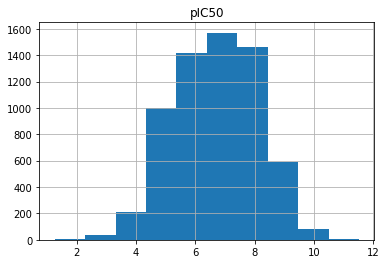

In [67]:
output_df.hist(column="pIC50")

In [69]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [70]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

In [71]:
# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL63786,0.003,nM,11.522879,
1,CHEMBL35820,0.006,nM,11.221849,
2,CHEMBL53711,0.006,nM,11.221849,
3,CHEMBL53753,0.008,nM,11.096910,
4,CHEMBL66031,0.008,nM,11.096910,
5,CHEMBL176582,0.010,nM,11.000000,
6,CHEMBL174426,0.025,nM,10.602060,
7,CHEMBL29197,0.025,nM,10.602060,
8,CHEMBL1243316,0.030,nM,10.522879,
9,CHEMBL3613702,0.037,nM,10.431798,

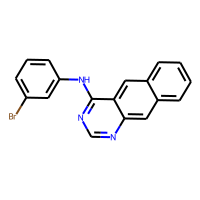
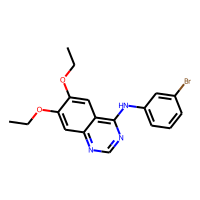
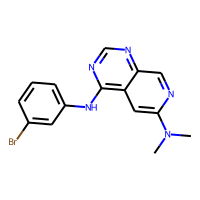
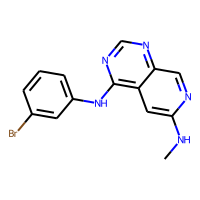
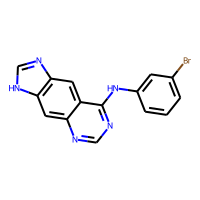
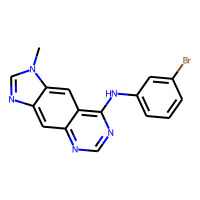
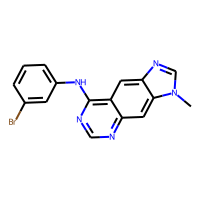
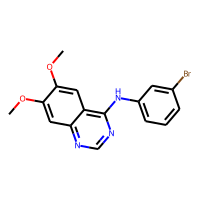
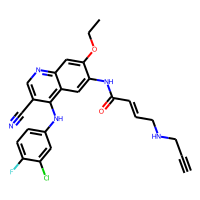
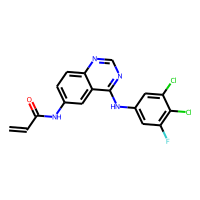

In [73]:
output_df.drop("smiles", axis=1).head(10)

In [75]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (6380, 5)


In [77]:
output_df.to_csv("EGFR_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


da qui 

In [ ]:
target = new_client.target                                     
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
print(targets)

In [18]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
print(res)

In [ ]:
df = pd.DataFrame.from_dict(res)
print(df)

In [ ]:
df.to_csv('acetylcholinesterase_bioactivity_data.csv', index=False)

In [ ]:
act_normal = df[df.standard_value.notna()]
act_normal = act_normal[act_normal.canonical_smiles.notna()]
act_normal = act_normal.drop_duplicates(['canonical_smiles'])
act_normal

In [ ]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
new_act = act_normal[selection]
new_act

In [ ]:
new_act.to_csv('acetylcholinesterase_bioactivity_clear', index=False)

In [ ]:
# This is temporary line
new_act = pd.read_csv('acetylcholinesterase_bioactivity_clear')

In [ ]:
bioactivity_threshold = []
for i in new_act.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append('inactive')
  elif float(i) <= 1000:
    bioactivity_threshold.append('active')
  else:
    bioactivity_threshold.append('intermediate')
bioactivity_class = pd.Series(bioactivity_threshold, name = 'bioactivity_class')
act5 = pd.concat([new_act, bioactivity_class], axis=1)
act5

In [ ]:
act5 = act5.dropna()
act5

In [ ]:
act5.to_csv('bioactivity_with_class.csv', index=False)

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
act_nosmiles = act5.drop(columns='canonical_smiles')
smiles = []

for i in act5.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name='canonical_smiles')
act_clean_smiles = pd.concat([act_nosmiles,smiles], axis=1)
act_clean_smiles

In [ ]:

def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)
    baseData = np.arange(1, 1)
    i = 0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
  
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])
        if (i==0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1

    columnNames =  ["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    return descriptors


In [ ]:
act_lipinski = lipinski(act_clean_smiles.canonical_smiles)
act_lipinski

In [ ]:
act_comb = pd.concat([act5, act_lipinski], axis = 1)
act_comb

normalizing standard values

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
act_norm = norm_value(act_comb)
act_norm

converting to pIC50

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
act_final = pIC50(act_norm)
act_final

In [ ]:
act_final.to_csv('bioactvity_pIC50.csv')

Exploratory data analysis (chemical space analysis) via lipinski descriptors

In [ ]:
act_fn = act_final[act_final['bioactivity_class'] != 'intermediate']
act_fn

frequency of 2 classes (active, inactive)

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_class', data=act_fn, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('plot_bioactivity_class.pdf')

making statistical analysis

In [ ]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = act_fn[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = act_fn[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [ ]:
mannwhitney('pIC50')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW value', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=act_fn, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP value', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [ ]:
mannwhitney('LogP')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDon value', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDon.pdf')

In [ ]:
mannwhitney('NumHDonors')

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcc value', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcc.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

results interpretation

All of the four Lipinski descriptors exhibited statistically significant difference between active and inactive molecules.

let's calculate other descriptors with PADEL

In [ ]:
! wget https://github.com/gromdimon/features/raw/main/padel.sh
! wget https://github.com/gromdimon/features/raw/main/padel.zip

In [ ]:
!unzip padel.zip

In [ ]:
act_final

In [ ]:
selection = ['canonical_smiles', 'molecule_chembl_id']
act_selected = act_final[selection]
act_selected.to_csv('molecule.smi', sep='\t', index=False, header=False )

In [ ]:
! cat molecule.smi | head -5
! cat molecule.smi | wc -l

In [ ]:
!cat padel.sh

In [ ]:
!bash padel.sh

In [ ]:
!ls -l

preparing data for later researchs

In [ ]:
actx = pd.read_csv('descriptors_output.csv')
actx

In [ ]:
actx = actx.drop(columns='Name')
actx


In [ ]:
actx.to_csv('actx.csv')

In [ ]:
acty = act_final['pIC50']
acty

In [ ]:
actx.shape

In [ ]:
acty.shape

making new datase

In [ ]:
datasetxy = pd.concat([actx, acty], axis=1)
datasetxy

In [ ]:
datasetxy.to_csv('dataset_with_padel_pIC50.csv', index=False)